In [1]:
from utils import imshow, visualize_model
from forNoise import AddGaussianNoise
from train import train_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2

cudnn.benchmark = True
plt.ion()   # interactive mode

Import tensorboard for model training and testing visualization:

In [2]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" 
writer = SummaryWriter('runs/Gestures')

First we construct the Datasets with the transforms and the dataloaders:

In [3]:
from torchvision.transforms.transforms import ColorJitter
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ColorJitter(0.5,0.5,0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomApply([AddGaussianNoise(0., 1.)],p=0.2)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224), # resize to 224?
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomApply([AddGaussianNoise(0., 1.)],p=0.4)
    ]),
}

# Dataset and Data_loader definition
data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Choose the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Here we see some preprocessed images from the training dataset:

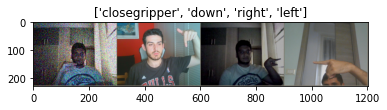

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Then we import the MobileNetv2 model and we define the Loss criterium, the optimizer and the learning scheduler: 

In [5]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in C:\Users\anto1/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\anto1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\anto1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We train the model and visualize some predictions on the test dataset:

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, device, dataloaders, dataset_sizes, writer,
                       num_epochs=18)

torch.save(model_ft.state_dict(), 'model_weights.pth')

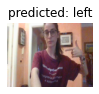

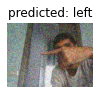

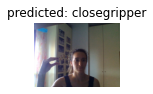

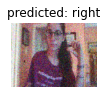

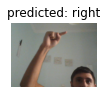

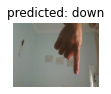

In [6]:
model_ft.load_state_dict(torch.load('model_weights.pth'))
model_ft.eval()

visualize_model(model_ft, device, dataloaders, class_names)

Finally we visualize the prediction on a live video from the pc webcam:

In [13]:
from zmqRemoteApi import RemoteAPIClient

print('Program started')

client = RemoteAPIClient('localhost', 23000)
sim = client.getObject('sim')

executedMovId = 'notReady'
targetArm = '/LBR4p'
stringSignalName = targetArm + '_executedMovId'
objHandle = sim.getObject(targetArm)
scriptHandle = sim.getScript(sim.scripttype_childscript,objHandle)


def waitForMovementExecuted(id_):
    global executedMovId, stringSignalName
    while executedMovId != id_:
        s = sim.getStringSignal(stringSignalName)
        executedMovId = s


# Set-up some movement variables:
maxVel = 0.1
maxAccel = 0.01

# Start simulation:
sim.startSimulation()

# Wait until ready:
waitForMovementExecuted('ready')

# Get initial pose:
initialPose, initialConfig = sim.callScriptFunction('remoteApi_getPoseAndConfig',scriptHandle)

open_gripper = True
sim.callScriptFunction('remoteApi_opencloseGripper', scriptHandle, open_gripper)

initialPose = [-0.2, 0, 0.7, 0, -np.pi/2, 0, 1]
movementData = {
    'id': 'movSeq1',
    'type': 'mov',
    'targetPose': initialPose,
    'maxVel': maxVel,
    'maxAccel': maxAccel
}
sim.callScriptFunction('remoteApi_movementDataFunction',scriptHandle,movementData)

# Execute first movement sequence:
sim.callScriptFunction('remoteApi_executeMovement',scriptHandle,'movSeq1')

# Wait until above movement sequence finished executing:
waitForMovementExecuted('movSeq1')



Program started


In [14]:
from IPython.display import Image
from PIL import Image

cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
state = 'ready'

# parameters to limit movements
counter_horizontal = 0
counter_vertical = 0
limit = 5
id_val = 1

while True:
    ret, frame = cap.read()
    img = np.array(frame)
    
    # convert from openCV2 to PIL. Notice the COLOR_BGR2RGB which means that 
    # the color is converted from BGR to RGB
    color_coverted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_np=Image.fromarray(color_coverted)

    # preprocessing of the frame
    input_tensor = data_transforms['val'](image_np)
    input_batch = input_tensor.unsqueeze(0)

    # giving the frame as input to the ConvNet
    input = input_batch.to(device)
    model_ft.to(device)

    with torch.no_grad():
      output = model_ft(input)
    
    output = torch.softmax(output, 1)
    _, preds = torch.max(output, 1)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    prob = _.cpu().numpy()[0]
    label = class_names[preds]

    font = cv2.FONT_HERSHEY_SIMPLEX
    frame = cv2.putText(frame, label+ ' ' + np.format_float_positional(prob),(10,30), font, 1,(0,0,255),2,cv2.LINE_AA)
    cv2.imshow('gesture_detection',  cv2.resize(frame, (800, 600)))
    
    if prob > 0.98 and label != 'stop' and label != 'closegripper':
        id_val += 1

        currentPose, currentConfig = sim.callScriptFunction('remoteApi_getPoseAndConfig',scriptHandle)

        # Send movement sequence:
        if label == 'up' and counter_vertical < limit:
          variat = [0, 0, 0.02, 0, 0, 0, 0]
          counter_vertical += 1
        elif label == 'down' and counter_vertical > -limit:
          variat = [0, 0, -0.02, 0, 0, 0, 0]
          counter_vertical -= 1
        elif label == 'right' and counter_horizontal < limit:
          variat = [0, 0.02, 0, 0, 0, 0, 0]
          counter_horizontal += 1
        elif label == 'left' and counter_horizontal > -limit:
          variat = [0, -0.02, 0, 0, 0, 0, 0]
          counter_horizontal -= 1

        targetPose = initialPose
        targetPose[:3] = [sum(x) for x in zip(currentPose[:3], variat[:3])]
        print(targetPose)
        id_str = 'movSeq' + str(id_val)
        movementData = {
            'id': id_str,
            'type': 'mov',
            'targetPose': targetPose,
            'maxVel': maxVel,
            'maxAccel': maxAccel
        }
        sim.callScriptFunction('remoteApi_movementDataFunction',scriptHandle,movementData)

        # Execute first movement sequence:
        sim.callScriptFunction('remoteApi_executeMovement',scriptHandle,id_str)

        # Wait until above movement sequence finished executing:
        waitForMovementExecuted(id_str)
    elif prob > 0.98 and label == 'stop':
        open_gripper = True
        sim.callScriptFunction('remoteApi_opencloseGripper', scriptHandle, open_gripper)
    elif prob > 0.98 and label == 'closegripper':
        open_gripper = False
        sim.callScriptFunction('remoteApi_opencloseGripper', scriptHandle, open_gripper)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

sim.stopSimulation()

print('Program ended')

[-0.20007844269275665, -2.1779967937618494e-05, 0.6996825933456421, -0.000246365467319265, -0.7076302766799927, 0.0006221611984074116, 0.7065826058387756]
[-0.20007844269275665, -2.1779967937618494e-05, 0.6796825933456421, 0, -1.5707963267948966, 0, 1]
[-0.1989298015832901, -0.00034574687015265226, 0.6869977712631226, 0.0003842006262857467, -0.7018061280250549, 0.000317997153615579, 0.7123678922653198]
[-0.1989298015832901, -0.00034574687015265226, 0.6669977712631225, 0, -1.5707963267948966, 0, 1]
Program ended


In [10]:
# in case something goes wrong
sim.stopSimulation()

0